In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv


# Loading packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from lightgbm import LGBMClassifier


# Data Loading

In [3]:
train = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv')
movies = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv')
test = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv')

# Merging Train data with movies.csv (meta data)

In [4]:
movie = movies.drop_duplicates(subset=['movieid'])
tr = pd.merge(train,movie, on='movieid', how='left')

In [5]:
x = tr.drop(['sentiment'], axis=1)
y = tr['sentiment']

In [6]:
print('shape of train features',x.shape)
print('shape of train labels',y.shape)

shape of train features (162758, 17)
shape of train labels (162758,)


# Data Exploration

In [7]:
x.head() #Features

,movieid,reviewerName,isFrequentReviewer,reviewText,title,audienceScore,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType
0,marvelous_pirate,Benjamin Henry,False,Henry Selick’s first movie since 2009’s Corali...,Marvelous Pirate,65.0,PG-13,"['Violence', 'Brief Strong Language', 'Substan...",2022-10-21,2022-10-28,105.0,"Comedy, Animation, Adventure, Fantasy",English,Bennie Basso,NaN,Netflix,NaN
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,With a cast that reads like the Vogue Oscar pa...,Tony Montana Frodo Baggins V Rocky Balboa,NaN,NaN,NaN,NaN,2013-01-08,91.0,Action,English,Alma White,NaN,NaN,NaN
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,True,Creed II does not give us anything but another...,Darth Vader Katniss Everdeen Sorcerer Donnie D...,80.0,PG-13,"['Language', 'A Scene of Sensuality', 'Sports ...",2018-11-21,2019-02-12,130.0,Drama,English,Bobby Oleary,$115.7M,"Warner Bros. Pictures, Metro-Goldwyn-Mayer",NaN
3,lara_croft_glimmer,Ryan Barrett,False,"I know what you're thinking, but this is no Li...",Lara Croft Glimmer,NaN,NaN,NaN,NaN,2020-06-02,15.0,Drama,Spanish,Eric Hutcherson,NaN,NaN,NaN
4,jason_bourne_surreal_the_terminator_indiana_jones,Alexander Glover,False,Director Fernando Meirelles tells the story wi...,Jason Bourne Surreal The Terminator Indiana Jones,97.0,R,"['Language', 'Drug Content', 'Sexuality', 'Str...",2003-01-17,2004-06-08,131.0,"Crime, Drama",Portuguese (Brazil),John Trent,$7.6M,Miramax Films,"Surround, Dolby SR, Dolby Digital, Dolby A, Do..."


In [8]:
x.columns

Index(['movieid', 'reviewerName', 'isFrequentReviewer', 'reviewText', 'title',
       'audienceScore', 'rating', 'ratingContents', 'releaseDateTheaters',
       'releaseDateStreaming', 'runtimeMinutes', 'genre', 'originalLanguage',
       'director', 'boxOffice', 'distributor', 'soundType'],
      dtype='object')

In [9]:
#Label column
y.head()

0    POSITIVE
1    NEGATIVE
2    POSITIVE
3    POSITIVE
4    POSITIVE
Name: sentiment, dtype: object

In [10]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162758 entries, 0 to 162757
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   movieid               162758 non-null  object 
 1   reviewerName          162758 non-null  object 
 2   isFrequentReviewer    162758 non-null  bool   
 3   reviewText            156311 non-null  object 
 4   title                 162758 non-null  object 
 5   audienceScore         149510 non-null  float64
 6   rating                99034 non-null   object 
 7   ratingContents        99034 non-null   object 
 8   releaseDateTheaters   126924 non-null  object 
 9   releaseDateStreaming  146573 non-null  object 
 10  runtimeMinutes        159382 non-null  float64
 11  genre                 160320 non-null  object 
 12  originalLanguage      159468 non-null  object 
 13  director              162758 non-null  object 
 14  boxOffice             109982 non-null  object 
 15  

In [11]:
x.isnull().sum()

movieid                     0
reviewerName                0
isFrequentReviewer          0
reviewText               6447
title                       0
audienceScore           13248
rating                  63724
ratingContents          63724
releaseDateTheaters     35834
releaseDateStreaming    16185
runtimeMinutes           3376
genre                    2438
originalLanguage         3290
director                    0
boxOffice               52776
distributor             40663
soundType               85367
dtype: int64

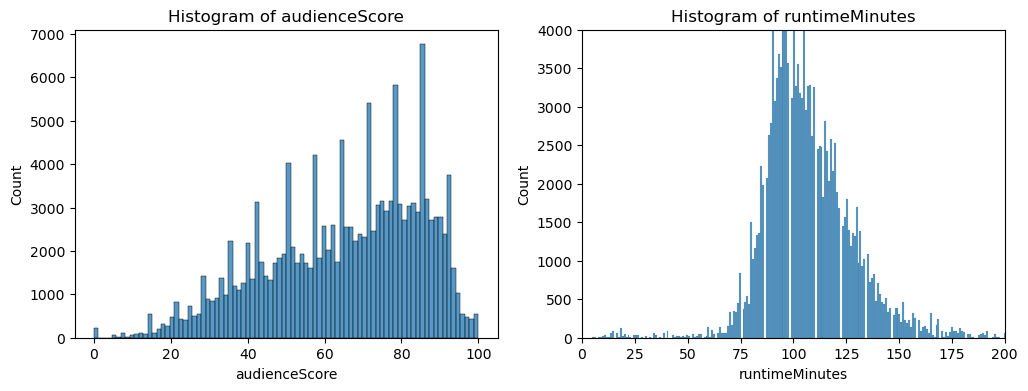

In [12]:
features = ['audienceScore', 'runtimeMinutes']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axes = axes.flatten()

for i, feature in enumerate(features):
    sns.histplot(data=x, x=feature, ax=axes[i])
    ax=axes[i]
    axes[i].set_title(f'Histogram of {feature}')
    if(i ==1):
        ax.set_xlim(0, 200)  
        ax.set_ylim(0, 4000)

plt.show()

**most of the audienceScore is around 90 (approx.)**

**most of the movies have runtimeMinutes around 90-120 minutes (approx.)**

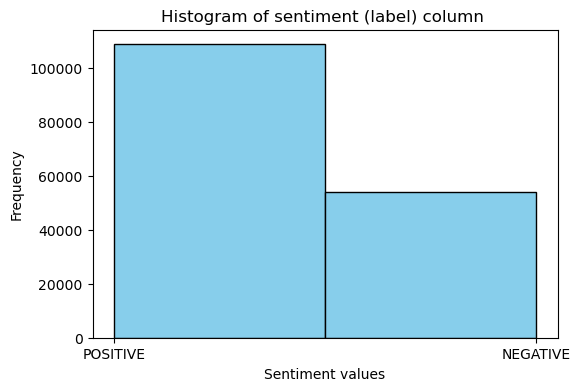

In [13]:
label_column = 'sentiment'

plt.figure(figsize=(6, 4))
plt.hist(tr[label_column], bins=len(tr[label_column].unique()), color='skyblue', edgecolor='black')
plt.title(f'Histogram of {label_column} (label) column ')
plt.xlabel('Sentiment values')
plt.ylabel('Frequency')

plt.show()
#This graph clearly shows that there is imbalance in the label column.
# 'POSITIVE' label has more representation than 'NEGATIVE' label

# Data Preprocessing on train data

In [14]:
s = Pipeline([('simple', SimpleImputer(missing_values = np.nan, strategy='most_frequent'))])
df = s.fit_transform(x)
td = pd.DataFrame(df, columns=x.columns)

In [15]:
td.isnull().sum()

movieid                 0
reviewerName            0
isFrequentReviewer      0
reviewText              0
title                   0
audienceScore           0
rating                  0
ratingContents          0
releaseDateTheaters     0
releaseDateStreaming    0
runtimeMinutes          0
genre                   0
originalLanguage        0
director                0
boxOffice               0
distributor             0
soundType               0
dtype: int64

In [16]:
td.describe().T #key statistics of the data

,count,unique,top,freq
movieid,162758,16812,escape_the_terminator_tyler_durden_astonish,708
reviewerName,162758,4482,Sherri Morrison,962
isFrequentReviewer,162758,2,False,113189
reviewText,162758,155071,Parental Content Review,6476
title,162758,16812,Escape The Terminator Tyler Durden Astonish,708
audienceScore,162758.0,100.0,86.0,16881.0
rating,162758,7,R,114055
ratingContents,162758,4477,['Language'],66046
releaseDateTheaters,162758,4226,2019-11-01,36293
releaseDateStreaming,162758,2899,2017-05-22,16838


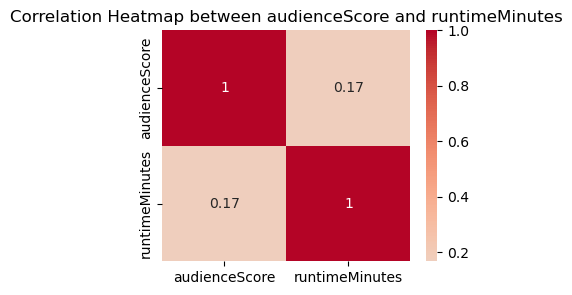

In [17]:
graphdata = td.copy()
graphdata['audienceScore'] = pd.to_numeric(graphdata['audienceScore'], errors='coerce')
graphdata['runtimeMinutes'] = pd.to_numeric(graphdata['runtimeMinutes'], errors='coerce')

# Calculate the correlation matrix
corr_matrix = graphdata[['audienceScore', 'runtimeMinutes']].corr()

# Create a heatmap using Seaborn
plt.figure(figsize=(4, 3))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title(f'Correlation Heatmap between audienceScore and runtimeMinutes')
plt.show()

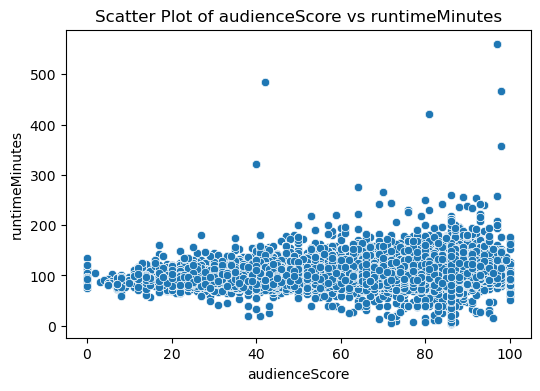

In [18]:
plt.figure(figsize=(6, 4))
sns.scatterplot(data=graphdata, x='audienceScore', y='runtimeMinutes')
plt.title('Scatter Plot of audienceScore vs runtimeMinutes')
plt.xlabel('audienceScore')
plt.ylabel('runtimeMinutes')
plt.show()
# Clearly these two numeric features do not have any correlation

In [19]:
# Manual Feature Selection done by hit and trial method
numerical_features = ['audienceScore', 'runtimeMinutes']
categorical_features = ['isFrequentReviewer']

In [20]:
# Transformer for numerical columns
num_pipe = Pipeline([('scaler', StandardScaler())])

# Transformer for categorical columns
cat_pipe = Pipeline([('ordinal', OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))])

# Transformer for 'reviewText' column 
tfidf = TfidfVectorizer(stop_words='english')  


In [21]:
col_trans = ColumnTransformer(transformers=[
    ('num', num_pipe, numerical_features), 
    ('cat', cat_pipe, categorical_features),
    ('text', tfidf, 'reviewText') 
])


X = col_trans.fit_transform(td)

# Splitting data in train and eval

In [22]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#splitting the data into train and eval(test) with 80% train data and 20% test data 

# Preprocessing on Test data

In [23]:
test = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv")

In [24]:
new_column_names = {'isTopCritic': 'isFrequentReviewer'}
test.rename(columns=new_column_names, inplace=True)

In [25]:
test = pd.merge(test,movie, on='movieid', how='left')

In [26]:
test.isnull().sum()

movieid                     0
reviewerName                0
isFrequentReviewer          0
reviewText               2510
title                       0
audienceScore            4931
rating                  24296
ratingContents          24296
releaseDateTheaters     13702
releaseDateStreaming     5974
runtimeMinutes           1262
genre                     920
originalLanguage         1238
director                    0
boxOffice               19995
distributor             15596
soundType               30626
dtype: int64

In [27]:
tes = s.transform(test) # imputing values in test data
td = pd.DataFrame(tes, columns=test.columns)
td.isna().sum()

movieid                 0
reviewerName            0
isFrequentReviewer      0
reviewText              0
title                   0
audienceScore           0
rating                  0
ratingContents          0
releaseDateTheaters     0
releaseDateStreaming    0
runtimeMinutes          0
genre                   0
originalLanguage        0
director                0
boxOffice               0
distributor             0
soundType               0
dtype: int64

In [28]:
test_data = col_trans.transform(td) # transforming using column transformer

In [29]:
print('Shape of test data',test_data.shape)

Shape of test data (55315, 64915)


# Logistic Regression Model

In [30]:
logReg_model =LogisticRegression(max_iter=5000)

In [31]:
param_grid = {
    'C': [0.1, 1]  
}

grid_search = GridSearchCV(logReg_model, param_grid, cv=2, scoring='accuracy')
grid_search.fit(x_train, y_train)


best_params = grid_search.best_params_
print(best_params)
# {'C': 1}
print(grid_search.best_estimator_)
# LogisticRegression(C=1, max_iter=5000)

{'C': 1}
LogisticRegression(C=1, max_iter=5000)


In [32]:
#logReg_best_model = grid_search.best_estimator_
logReg_best_model =LogisticRegression(C=1, max_iter=5000) #got from the best_estimator_ after hpt
logReg_best_model.fit(x_train, y_train)  
logReg_pred = logReg_best_model.predict(x_test)

In [33]:
logReg_accuracy = accuracy_score(y_test, logReg_pred)
print("Logistic Regression Accuracy:", logReg_accuracy)

Logistic Regression Accuracy: 0.8036372573113787


In [34]:
print("Train score = ",logReg_best_model.score(x_train,y_train))
print("Test score = ",logReg_best_model.score(x_test,y_test))

Train score =  0.8417814847242062
Test score =  0.8036372573113787


In [35]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, logReg_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[ 6287  4409]
 [ 1983 19873]]

True Positives(TP) =  6287

True Negatives(TN) =  19873

False Positives(FP) =  4409

False Negatives(FN) =  1983


<Axes: >

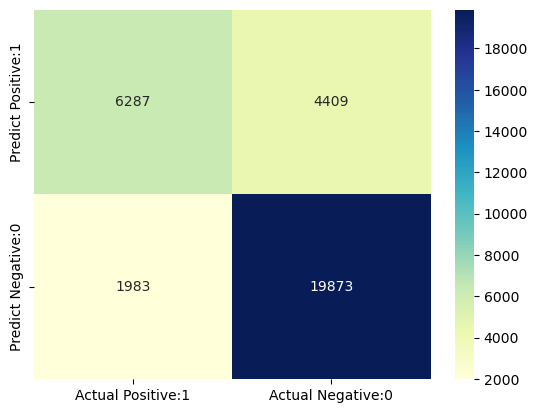

In [36]:

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

# SGD Classifier Model

In [37]:

sgd_model = SGDClassifier(max_iter=1000, random_state=42)

In [38]:
#HPT
param_grid = {
    'loss': ['hinge', 'log_loss'],
    'alpha': [0.0001, 0.001, 0.01, 1, 10],
    'penalty': ['l2', 'l1', 'elasticnet']
}

grid_search_SGD = GridSearchCV(sgd_model, param_grid, cv=2, scoring='accuracy')
grid_search_SGD.fit(x_train, y_train)


best_params = grid_search_SGD.best_params_
print(best_params)
#{'alpha': 0.0001, 'loss': 'hinge', 'penalty': 'l2'}
print(grid_search_SGD.best_estimator_)
#SGDClassifier(random_state=42)

{'alpha': 0.0001, 'loss': 'hinge', 'penalty': 'l2'}
SGDClassifier(random_state=42)


In [39]:
# sgd_best_model = grid_search_SGD.best_estimator_
sgd_best_model = SGDClassifier(alpha = 0.0001, loss= 'hinge', penalty= 'l2',random_state=42)
sgd_best_model.fit(x_train, y_train)  
sgd_pred = sgd_best_model.predict(x_test)

In [40]:
sgd_accuracy = accuracy_score(y_test, sgd_pred)
print("SGD Classifier Accuracy:", sgd_accuracy)


SGD Classifier Accuracy: 0.7778323912509216


In [41]:
print("Train score = ",sgd_best_model.score(x_train,y_train))
print("Test score = ",sgd_best_model.score(x_test,y_test))

Train score =  0.7905856872955164
Test score =  0.7778323912509216


In [42]:
from sklearn.metrics import confusion_matrix
cm2 = confusion_matrix(y_test, sgd_pred)
print('Confusion matrix\n\n', cm2)
print('\nTrue Positives(TP) = ', cm2[0,0])
print('\nTrue Negatives(TN) = ', cm2[1,1])
print('\nFalse Positives(FP) = ', cm2[0,1])
print('\nFalse Negatives(FN) = ', cm2[1,0])

Confusion matrix

 [[ 4763  5933]
 [ 1299 20557]]

True Positives(TP) =  4763

True Negatives(TN) =  20557

False Positives(FP) =  5933

False Negatives(FN) =  1299


<Axes: >

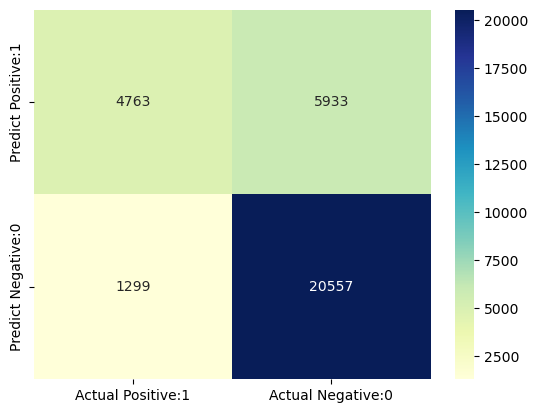

In [43]:
cm_matrix2 = pd.DataFrame(data=cm2, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix2, annot=True, fmt='d', cmap='YlGnBu')

# Lightgbm (LGBMClassifier) Model

In [44]:
lgb_model = LGBMClassifier()

In [45]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100,200, 300]
}

grid_search_lgb = GridSearchCV(lgb_model, param_grid, cv=2, scoring='accuracy')
grid_search_lgb.fit(x_train, y_train)


best_params = grid_search_lgb.best_params_
print(best_params)
#{'learning_rate': 0.2, 'n_estimators': 300}


print(grid_search_lgb.best_estimator_)
#LGBMClassifier(learning_rate=0.2, n_estimators=300)

{'learning_rate': 0.2, 'n_estimators': 300}
LGBMClassifier(learning_rate=0.2, n_estimators=300)


In [46]:
best_lgb_model = LGBMClassifier(learning_rate=0.2, n_estimators=300)

best_lgb_model.fit(x_train, y_train) 
lgb_pred = best_lgb_model.predict(x_test)


lgb_accuracy = accuracy_score(y_test, lgb_pred)
print("LightGBM Accuracy:", lgb_accuracy)

LightGBM Accuracy: 0.7958343573359548


In [47]:
#to check overfitting,  compare train score and test score
print('Train Score = ',best_lgb_model.score(x_train,y_train))
print('Test Score = ',best_lgb_model.score(x_test,y_test))

Train Score =  0.8352380074650938
Test Score =  0.7958343573359548


In [48]:
from sklearn.metrics import confusion_matrix
cm3 = confusion_matrix(y_test, lgb_pred)
print('Confusion matrix\n\n', cm3)
print('\nTrue Positives(TP) = ', cm3[0,0])
print('\nTrue Negatives(TN) = ', cm3[1,1])
print('\nFalse Positives(FP) = ', cm3[0,1])
print('\nFalse Negatives(FN) = ', cm3[1,0])

Confusion matrix

 [[ 6175  4521]
 [ 2125 19731]]

True Positives(TP) =  6175

True Negatives(TN) =  19731

False Positives(FP) =  4521

False Negatives(FN) =  2125


<Axes: >

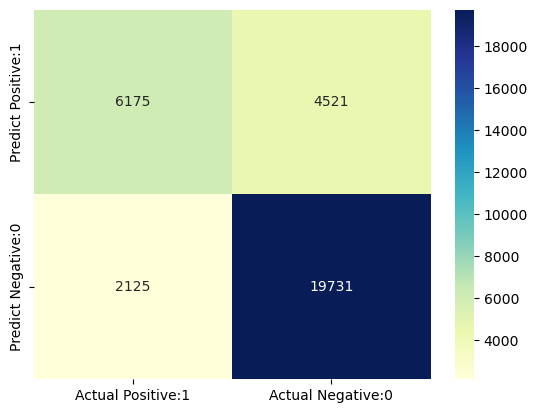

In [49]:
cm_matrix3 = pd.DataFrame(data=cm3, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix3, annot=True, fmt='d', cmap='YlGnBu')

# Inference (Comparison between three models)

**Classification Report for Logistic Regression Model**

In [50]:
print(classification_report(y_test, logReg_pred))

              precision    recall  f1-score   support

    NEGATIVE       0.76      0.59      0.66     10696
    POSITIVE       0.82      0.91      0.86     21856

    accuracy                           0.80     32552
   macro avg       0.79      0.75      0.76     32552
weighted avg       0.80      0.80      0.80     32552



**Classification Report for SGD Classifier Model**

In [51]:
print(classification_report(y_test, sgd_pred))

              precision    recall  f1-score   support

    NEGATIVE       0.79      0.45      0.57     10696
    POSITIVE       0.78      0.94      0.85     21856

    accuracy                           0.78     32552
   macro avg       0.78      0.69      0.71     32552
weighted avg       0.78      0.78      0.76     32552



**Classification Report for LightGB Model**

In [52]:
print(classification_report(y_test, lgb_pred))

              precision    recall  f1-score   support

    NEGATIVE       0.74      0.58      0.65     10696
    POSITIVE       0.81      0.90      0.86     21856

    accuracy                           0.80     32552
   macro avg       0.78      0.74      0.75     32552
weighted avg       0.79      0.80      0.79     32552



**Logistic Regression:**
The Logistic Regression model achieved an **accuracy of approximately 80%**. While it exhibited a balanced precision and recall for both positive and negative sentiments, it tended to have a slightly higher recall for positive sentiments. This means that the model is effective at identifying positive sentiments, and its overall performance is robust.

**SGD Classifier:**
The SGD Classifier, with an **accuracy of 77%**, showcased a significant recall for positive sentiments (94%) but relatively lower precision and recall for negative sentiments (45%). This indicates that the model might be more sensitive to detecting positive sentiments, potentially leading to higher false positives for negative sentiments.

**LightGBM:**
The LightGBM model achieved an **accuracy of 79%**, similar to the Logistic Regression model. It demonstrated a good balance between precision and recall for both positive and negative sentiments. However, it had a slightly higher precision for negative sentiments compared to the Logistic Regression model.

Overall Comparison:
# The **Logistic Regression is the best model because it gave the Best Test score** as compared to other models. Hence it was selected as the final model.



# Creating submission 

In [53]:
#Best model out of the three was logistic Regression model based on the test score
predictions = logReg_best_model.predict(test_data)

In [54]:
sub = pd.DataFrame(columns = ['id','sentiment'])
sub['id']=[i for i in range(len(predictions))]
sub['sentiment']=predictions
#sub.head()

In [55]:
sub.to_csv("submission.csv", encoding='utf-8',index=False)
output = pd.read_csv("submission.csv")
# output
